In [1]:
import os
import nest_asyncio
nest_asyncio.apply()

import pyshark

import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autotime

time: 119 µs (started: 2021-07-31 15:58:54 +00:00)


In [3]:
## Loading data

time: 9.85 ms (started: 2021-07-31 15:58:54 +00:00)


In [4]:
def loadDataset(path, extraId=""):
    cap = pyshark.FileCapture(path, use_json=True, include_raw=True)
    cap.load_packets()
    raw_data_list = [c.get_raw_packet() for c in cap]

    dataset = []
    
    for raw_data in raw_data_list:
        arr = np.zeros((75, 20, 3), dtype=np.uint8)
        x, y = 0, 0
        for e in raw_data:
            arr[x, y] = [e, e, e]
            x += 1
            if x == 75:
                x = 0
                y += 1
            if y == 20:
                break
        dataset.append(arr)  
    return np.asarray(dataset)

time: 1.53 ms (started: 2021-07-31 15:58:54 +00:00)


In [5]:
def frameToImg(frame):
    return Image.fromarray(frame, 'RGB')

time: 2.24 ms (started: 2021-07-31 15:58:54 +00:00)


In [6]:
badQueries = loadDataset('./dataset/badHttpQueriesFiltered.pcap')

badCount = len(badQueries)

time: 1min 13s (started: 2021-07-31 15:58:54 +00:00)


In [7]:
badCount

153824

time: 2.45 ms (started: 2021-07-31 16:00:07 +00:00)


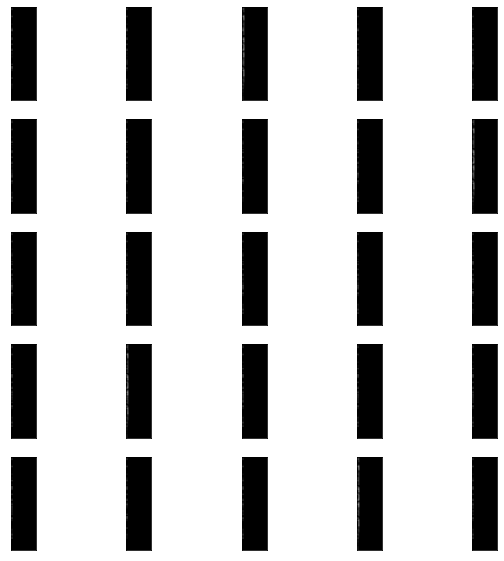

time: 594 ms (started: 2021-07-31 16:00:07 +00:00)


In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(badQueries[i]))
plt.show()

In [9]:
validQueries = loadDataset('./dataset/goodHttpQueriesFiltered.pcap')

validCount = len(validQueries)

time: 1min 16s (started: 2021-07-31 16:00:08 +00:00)


In [10]:
validCount

148962

time: 1.73 ms (started: 2021-07-31 16:01:25 +00:00)


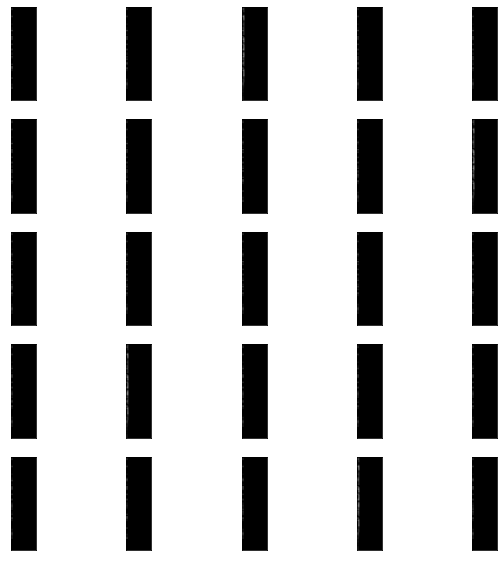

time: 607 ms (started: 2021-07-31 16:01:25 +00:00)


In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(validQueries[i]))
plt.show()

In [12]:
## Preparing the dataset

time: 205 µs (started: 2021-07-31 16:01:25 +00:00)


In [13]:
yBad = [1 for i in range(0, len(badQueries))]  #labels, 1 for malicious and 0 for clean
yGood = [0 for i in range(0, len(validQueries))]

time: 17.7 ms (started: 2021-07-31 16:01:25 +00:00)


In [14]:
X = np.concatenate((badQueries, validQueries), axis=0)
y = yBad + yGood

time: 148 ms (started: 2021-07-31 16:01:25 +00:00)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #splitting data

time: 241 ms (started: 2021-07-31 16:01:25 +00:00)


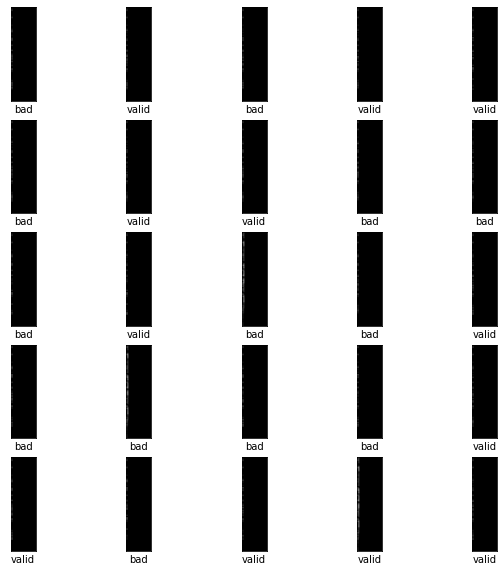

time: 631 ms (started: 2021-07-31 16:01:26 +00:00)


In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(X_test[i]))
    plt.xlabel("bad" if y_test[i] else "valid")
plt.show()

In [17]:
## Building the model

time: 201 µs (started: 2021-07-31 16:01:26 +00:00)


In [18]:
def gen_model(hidden_layer_count, hidden_layer_size, activation_fn='sigmoid'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation_fn, input_shape=(75, 20, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation_fn))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation_fn))

    model.add(Flatten())

    for _ in range(hidden_layer_count):
        model.add(Dense(hidden_layer_size, activation=activation_fn))
    model.add(Dense(1, activation='sigmoid'))
    
    #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

time: 7.53 ms (started: 2021-07-31 16:01:26 +00:00)


In [19]:
model = gen_model(6, 128, activation_fn='relu')

time: 84.8 ms (started: 2021-07-31 16:01:26 +00:00)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 18, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 9, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 7, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 1, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [21]:
## Training

time: 2.21 ms (started: 2021-07-31 16:01:26 +00:00)


In [22]:
def train_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=3)

    return model, test_loss, test_acc, history

time: 1.25 ms (started: 2021-07-31 16:01:26 +00:00)


In [23]:
test_acc = 0
model, test_loss, test_acc, history = train_model(model, 8, 32, X_train, y_train, X_test, y_test)

Epoch 1/10
7570/7570 [==============================] - 71s 9ms/step - loss: 0.6931 - accuracy: 0.5083 - val_loss: 0.6931 - val_accuracy: 0.5046
Epoch 2/10
7570/7570 [==============================] - 70s 9ms/step - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6932 - val_accuracy: 0.5046
Epoch 3/10
7570/7570 [==============================] - 70s 9ms/step - loss: 0.6930 - accuracy: 0.5087 - val_loss: 0.6931 - val_accuracy: 0.5046
Epoch 4/10
7570/7570 [==============================] - 70s 9ms/step - loss: 0.6930 - accuracy: 0.5087 - val_loss: 0.6931 - val_accuracy: 0.5046
Epoch 5/10
7570/7570 [==============================] - 70s 9ms/step - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6932 - val_accuracy: 0.5046
Epoch 6/10
7570/7570 [==============================] - 70s 9ms/step - loss: 0.6930 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5046
Epoch 7/10
7570/7570 [==============================] - 70s 9ms/step - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6931 - val_ac

KeyboardInterrupt: 

time: 12min 3s (started: 2021-07-31 16:01:26 +00:00)


In [ ]:
## Metrics

In [ ]:
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
## Testing

In [ ]:
def frame_is_bad(frame):
    return round(max(0., min(1., model.predict(np.asarray([frame]))[0][0])) * 100, 2)

In [ ]:
frameToImg(X_test[0])

In [ ]:
print("Is bad ?", frame_is_bad(X_test[0]), "%")